In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
import os
audio_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original"
print("Available genres:", os.listdir(audio_path))

In [ ]:
example_genre = os.listdir(audio_path)[0]  # Pick the first genre
example_genre_path = os.path.join(audio_path, example_genre)

print(f"Example genre ({example_genre}) files:", os.listdir(example_genre_path)[:5])

Til þess að nota þessi gögn geri ég

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# Select an example audio file (modify if needed)
example_audio_file = os.path.join(audio_path, "disco", "disco.00006.wav")  # Change genre & file if needed

# Load audio
y, sr = librosa.load(example_audio_file, sr=None)
print(f"Sample rate: {sr}, Audio shape: {y.shape}")

# Play the audio
ipd.Audio(y, rate=sr)

Sample rate: 22050, Audio shape: (661676,)


Við getum plottað waveformið svona. Fínt til að skoða hljóðskránna

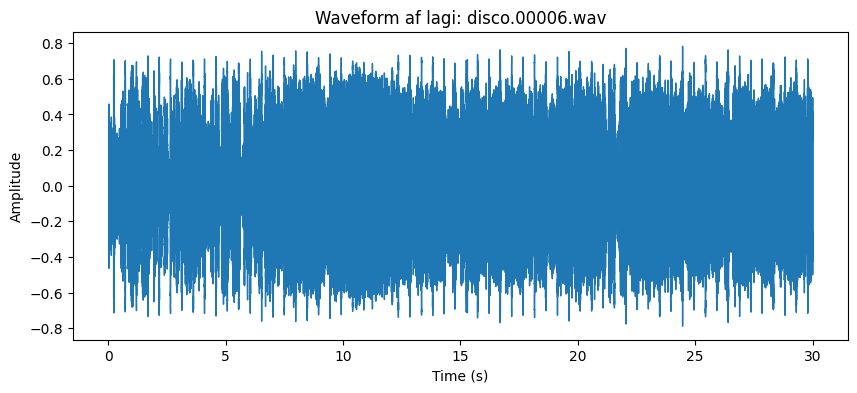

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform af lagi: disco.00006.wav")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Lélega recordingið á reggie laginu

Svona plottum við spectogram af lögum. Sýnir okkur hvernig tíðni breytist yfir tíma

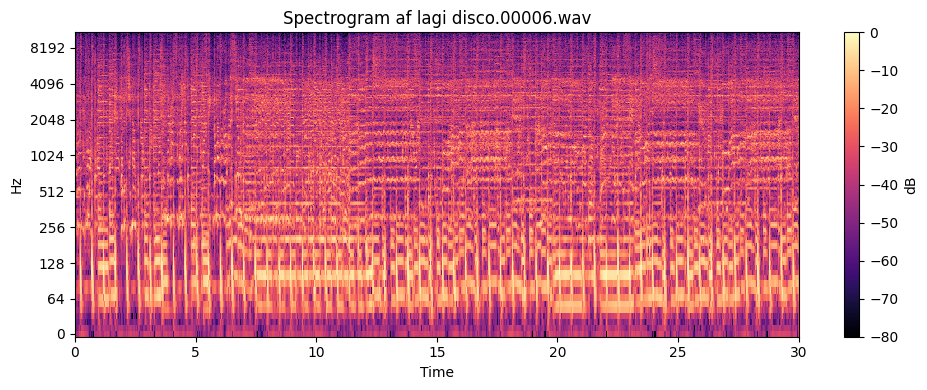

In [ ]:
import numpy as np

# Compute STFT
D = np.abs(librosa.stft(y))

# Convert to dB
spec_db = librosa.amplitude_to_db(D, ref=np.max)

# Plot Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(label="dB")
plt.title("Spectrogram af lagi disco.00006.wav")
plt.tight_layout()
plt.show()


Svona plottum við Mel Spectogram. Sýnir hvernig orka breytist á mismunandi tíðnisviðum

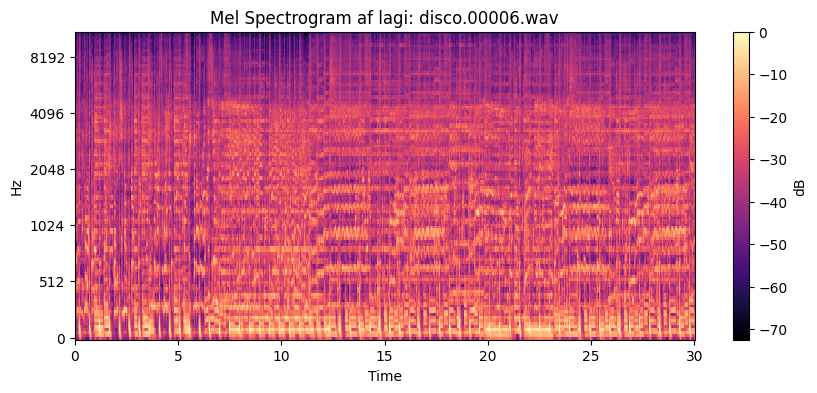

In [ ]:
import numpy as np

# Compute Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to Decibels
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title("Mel Spectrogram af lagi: disco.00006.wav")
plt.show()


Svoa plottum við MFCCs. Gott fyrir genre classification og speech recognition.

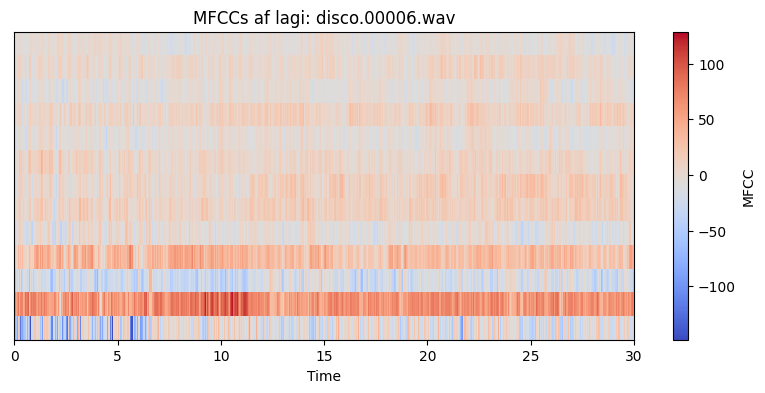

In [ ]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.colorbar(label="MFCC")
plt.title("MFCCs af lagi: disco.00006.wav")
plt.show()

Why Mel Spectrogram?

✅ Captures timbre & texture – Music genres have distinct frequency patterns and textures that a Mel Spectrogram retains well.

✅ Better for deep learning – Convolutional Neural Networks (CNNs) can learn patterns in Mel Spectrograms similar to how they learn from images.

✅ Preserves harmonic structure – Unlike MFCCs, which reduce frequency details, Mel Spectrograms retain important harmonics and rhythm features.

# Preprocessing gagna
Hérna tökum við allt gagnasettið og breytum í mel spectogram. Getum líka loadað því inn og sparað okkur tíma. T.d. getum við hlaðið inn sama lagi 'disco.00006.wav' svona

In [ ]:
import os
audio_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"
print("Available genres:", os.listdir(audio_path))

Available genres: ['images_original', 'genres_original', 'features_30_sec.csv', 'features_3_sec.csv']


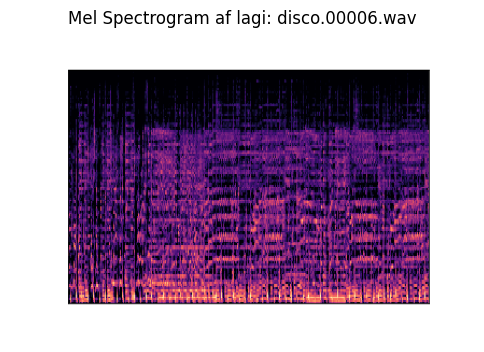

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the path to images
audio_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original"

# Select an example image file (modify if needed)
example_image_file = os.path.join(audio_path, "disco", "disco00006.png")  # Adjust file name if needed

# Load image using OpenCV
img = cv2.imread(example_image_file)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Mel Spectrogram af lagi: disco.00006.wav")
plt.show()

# Pre-trained classifier

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original"

# Image dimensions (adjust based on your dataset)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Check class labels
print("Class Labels:", train_data.class_indices)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.
Class Labels: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Loadum VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load pretrained VGG16 model (excluding top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pretrained layers (so we only train the classifier)
base_model.trainable = False

# Build our model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Þjálfum módelið

In [ ]:
EPOCHS = 30  # You can increase this for better results

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.5766 - loss: 1.2511 - val_accuracy: 0.5377 - val_loss: 1.3869
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.6048 - loss: 1.2096 - val_accuracy: 0.5930 - val_loss: 1.3866
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.6268 - loss: 1.2099 - val_accuracy: 0.5477 - val_loss: 1.3748
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.6246 - loss: 1.1543 - val_accuracy: 0.5427 - val_loss: 1.3672
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.6334 - loss: 1.1477 - val_accuracy: 0.5276 - val_loss: 1.3827
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.6250 - loss: 1.1331 - val_accuracy: 0.5528 - val_loss: 1.3713
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.6659 - loss: 1.0200 - val_accuracy: 0.5176 - val_loss: 1.3299
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.7209 - loss: 0.9751 - val_accuracy: 0

Performance

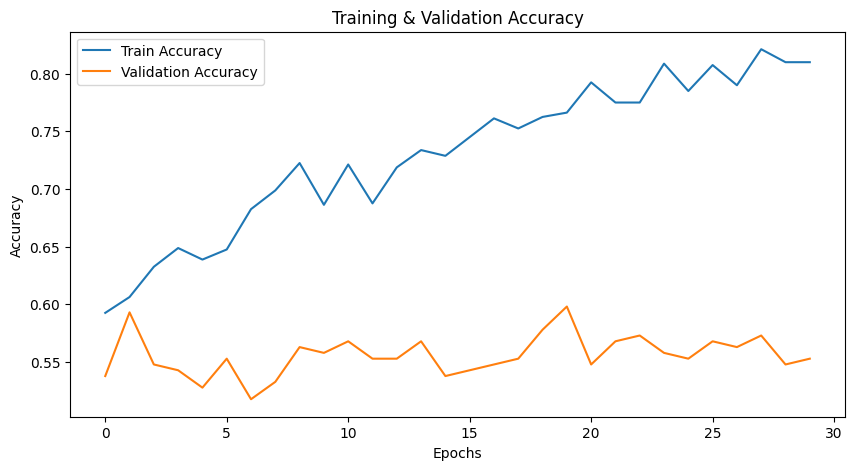

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

Save-um módelið

In [ ]:
model.save("music_genre_model.keras")

Downloada módelinu

In [ ]:
from google.colab import files
files.download("music_genre_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loadum því

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("music_genre_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Lagað módel sem minnkar overfitting

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 757ms/step - accuracy: 0.1216 - loss: 3.3540 - val_accuracy: 0.1055 - val_loss: 3.1529
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 0.1248 - loss: 3.2814 - val_accuracy: 0.1005 - val_loss: 3.1401
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 664ms/step - accuracy: 0.1031 - loss: 3.2808 - val_accuracy: 0.1055 - val_loss: 3.1274
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 678ms/step - accuracy: 0.1087 - loss: 3.2299 - val_accuracy: 0.1256 - val_loss: 3.1123
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 635ms/step - accuracy: 0.1017 - loss: 3.1958 - val_accuracy: 0.2111 - val_loss: 3.0872
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 0.1274 - loss: 3.1584 - val_accuracy: 0.2362 - val_loss: 3.0593
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 664ms/step - accuracy: 0.1266 - loss: 3.1519 - val_accuracy: 0.2362 - val_loss: 3.0328
Epoch 8/50
25

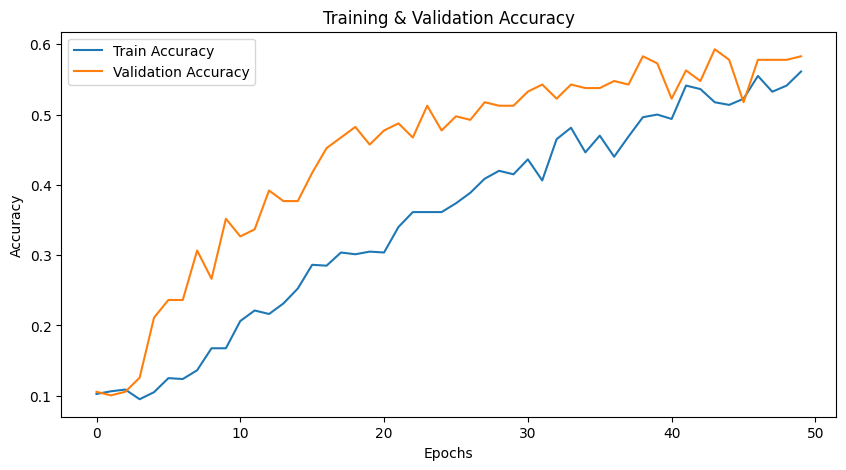

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Dataset Path
dataset_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original"

# Image Processing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

train_data = datagen.flow_from_directory(dataset_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training')
val_data = datagen.flow_from_directory(dataset_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation')

# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

# Fine-tune last 5 layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stopping])

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()


In [ ]:
model.save("music_genre_modelv2.keras")

Download-a módelinu

In [ ]:
from google.colab import files
files.download("music_genre_modelv2.keras")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("music_genre_modelv2.keras")

Gerum 150 með early stopping

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 845ms/step - accuracy: 0.0914 - loss: 3.3735 - val_accuracy: 0.0653 - val_loss: 3.1561
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 620ms/step - accuracy: 0.0946 - loss: 3.3097 - val_accuracy: 0.1156 - val_loss: 3.1377
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 714ms/step - accuracy: 0.1159 - loss: 3.2119 - val_accuracy: 0.1910 - val_loss: 3.1185
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 643ms/step - accuracy: 0.1221 - loss: 3.2032 - val_accuracy: 0.1457 - val_loss: 3.1024
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 615ms/step - accuracy: 0.1245 - loss: 3.1925 - val_accuracy: 0.2111 - val_loss: 3.0854
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 612ms/step - accuracy: 0.1529 - loss: 3.1455 - val_accuracy: 0.2211 - val_loss: 3.0589
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 714ms/step - accuracy: 0.1421 - loss: 3.1012 - val_accuracy: 0.2563 - val_loss: 3.0307
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 615ms/step - accuracy: 0.1503 - loss: 3.0744 - 

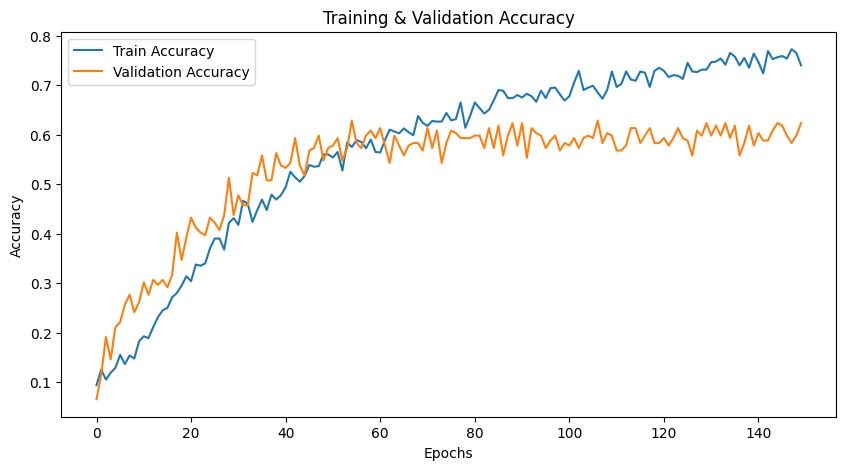

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Enable GPU Memory Growth (Optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Dataset Path
dataset_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original"

# Image Processing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

train_data = datagen.flow_from_directory(dataset_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='training')
val_data = datagen.flow_from_directory(dataset_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation')

# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

# Fine-tune last 5 layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(train_data, validation_data=val_data, epochs=150, callbacks=[early_stopping])

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()


In [ ]:
from google.colab import files
model.save("music_genre_modelv4.keras")
files.download("music_genre_modelv4.keras")

NameError: name 'model' is not defined

# Re download-a tauganetinu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/data_gervigreind/music_genre_modelv4.keras .

In [ ]:
from google.colab import files
files.download("music_genre_modelv4.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>